* EDA for formulation  

# Import Libraries and Data

In [1]:
import numpy as np
import pandas as pd
pd.get_option("display.max_columns")
pd.set_option('display.max_columns', 300)
pd.get_option("display.max_rows")
pd.set_option('display.max_rows', 300)

import matplotlib.pyplot as plt
%matplotlib inline

import os
from os.path import join as opj
import gc

INPUT_PATH = '../../input/feedback-prize-effectiveness/'

LABEL = 'discourse_effectiveness'

In [2]:
train_df = pd.read_csv(opj(INPUT_PATH, 'train.csv'))
test_df = pd.read_csv(opj(INPUT_PATH, 'test.csv'))
sub_df = pd.read_csv(opj(INPUT_PATH, 'sample_submission.csv'))

print('train_df.shape = ', train_df.shape)
print('test_df.shape = ', test_df.shape)
print('sub_df.shape = ', sub_df.shape)

train_df.shape =  (36765, 5)
test_df.shape =  (10, 4)
sub_df.shape =  (10, 4)


# Check Distribution

In [28]:
train_df.head(2)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,label_eff
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,1
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,1


In [4]:
train_df['discourse_effectiveness'].value_counts()

Adequate       20977
Effective       9326
Ineffective     6462
Name: discourse_effectiveness, dtype: int64

In [11]:
train_df['label_eff'] = train_df['discourse_effectiveness'].map({'Ineffective':0, 'Adequate':1, 'Effective':2})

In [29]:
essay_df = train_df.groupby('essay_id')['label_eff'].mean().reset_index()
essay_df.head(2)

,essay_id,label_eff
0,00066EA9880D,1.777778
1,000E6DE9E817,0.833333


(array([230.,   0.,   0.,   0.,   0.,   4.,   5.,   8.,  14.,   4.,  21.,
          7.,  29.,   1.,  21.,   4.,  93.,   0.,  15.,   0.,  41.,  18.,
         27.,   0.,   0., 153.,   3.,  38.,  42.,   8.,  80.,  53.,   1.,
        149.,  30.,  74.,  34., 172.,  77.,   3., 222., 193., 189., 173.,
        183., 250.,  90.,  13.,   0.,   0., 208.,   0.,   2.,  13.,  26.,
         30.,  17.,  16.,  11.,   8.,  15.,  16.,  11.,   7.,   4.,  12.,
          6.,   2.,   6.,   2.,   1.,   1.,   6.,   0.,   0.,   3.,   0.,
          1.,   1.,   1.,  32.,  88.,  28., 168.,  19.,  75.,  34.,  74.,
         78.,   7.,  60.,  34.,  47.,  27.,  66.,  35.,  14.,   5.,   0.,
        102.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

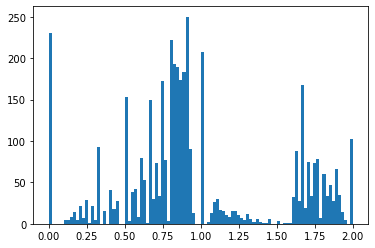

In [31]:
plt.hist(train_df.groupby('essay_id')['label_eff'].mean().values, bins=100)

In [32]:
def make_bin(x):
    if x<0.1:
        return 0
    elif x<1.6:
        return 1
    else:
        return 2
essay_df['label_eff_bin'] = essay_df['label_eff'].apply(lambda x:make_bin(x))

(array([ 230.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0., 2968.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         993.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58

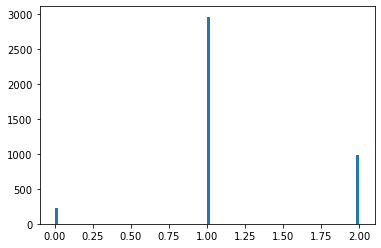

In [35]:
plt.hist(essay_df['label_eff_bin'].values, bins=100)

# Create Folds

In [38]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

def get_fold_ids_list(n_folds, ids, y, seed):
    kfold = StratifiedKFold(n_splits=n_folds,
                            shuffle=True,
                            random_state=seed)
    trn_ids_list = []
    val_ids_list = []
    for trn_idx, val_idx in kfold.split(y,y):
        trn_ids_list.append(ids[np.array(trn_idx)])
        val_ids_list.append(ids[np.array(val_idx)])
    return trn_ids_list, val_ids_list

In [39]:
N_FOLDS = 5
SEED = 100

trn_ids_list, val_ids_list = get_fold_ids_list(n_folds=N_FOLDS,
                                               ids=essay_df['essay_id'],
                                               y=essay_df['label_eff_bin'],
                                               seed=SEED)

In [40]:
import joblib
import os

os.makedirs('./result', exist_ok=True)
joblib.dump(trn_ids_list, './result/trn_ids_list.joblib')
joblib.dump(val_ids_list, './result/val_ids_list.joblib')

['./result/val_ids_list.joblib']

In [41]:
for fold in range(N_FOLDS):
    print('fold = ', fold)
    val_df = train_df[train_df['essay_id'].isin(val_ids_list[fold])].reset_index()
    display(val_df[LABEL].value_counts())
    print('')

fold =  0


Adequate       4189
Effective      1850
Ineffective    1264
Name: discourse_effectiveness, dtype: int64


fold =  1


Adequate       4244
Effective      1811
Ineffective    1327
Name: discourse_effectiveness, dtype: int64


fold =  2


Adequate       4199
Effective      1832
Ineffective    1273
Name: discourse_effectiveness, dtype: int64


fold =  3


Adequate       4201
Effective      1916
Ineffective    1300
Name: discourse_effectiveness, dtype: int64


fold =  4


Adequate       4144
Effective      1917
Ineffective    1298
Name: discourse_effectiveness, dtype: int64